# Port tensorflow ESPCN model to iOS using coremltools

**Author** Balázs Tibor Morvay

Model training code and some functions are from:
Image Super-Resolution using an Efficient Sub-Pixel CNN, [Xingyu Long](https://github.com/xingyu-long)<br>

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [29]:
saved_model = '/Users/balazsmorvay/Downloads/ESPCN/ESPCN_model'

In [30]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    # run["conv_args"] = conv_args
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [31]:
model = get_model(upscale_factor=4, channels=1)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    1664      
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space_1 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

In [32]:
model.load_weights(saved_model)

2023-05-31 10:53:25.252977: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open /Users/balazsmorvay/Downloads/ESPCN/ESPCN_model: FAILED_PRECONDITION: /Users/balazsmorvay/Downloads/ESPCN/ESPCN_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [33]:
import coremltools as ct

mlmodel = ct.convert(
                    model,
                    source='tensorflow',
                    convert_to='mlprogram',
                    inputs=[ct.TensorType(shape=(1, 64, 64, 1))])


2023-05-31 10:53:26.974140: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-05-31 10:53:27.039575: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
Running MIL backend_mlprogram pipeline: 100%|██████████| 10/10 [00:00<00:00, 5333.55 passes/s]


In [34]:
mlmodel.save('ESPCN.mlpackage')

In [35]:
import numpy as np
import PIL
from PIL import Image

In [36]:
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )

In [41]:
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()

    
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict({'input_2': input})

    out_img_y = out['Identity'][0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

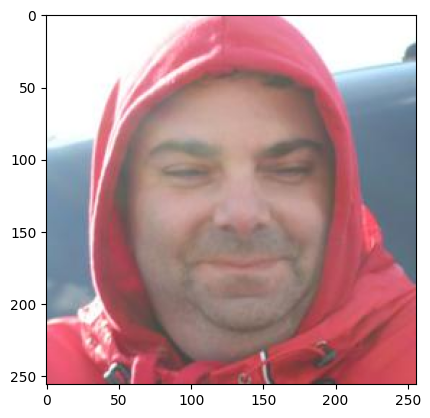

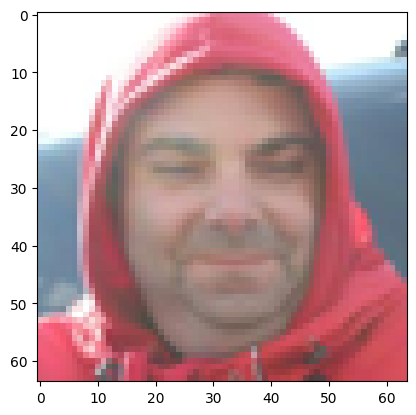

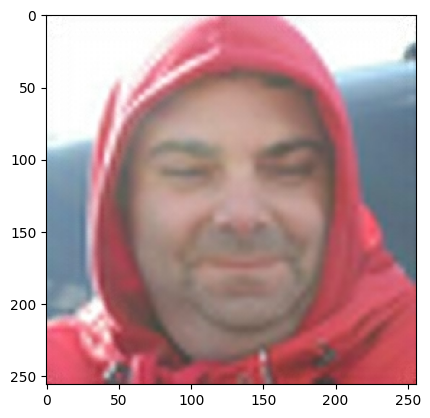

In [44]:
# Run the entire dataset through the network
from tqdm import tqdm
import torchvision.transforms as T
import torch
from einops import rearrange
from matplotlib import pyplot as plt
import os

crop_size = 256
upscale_factor = 4
input_size = crop_size // upscale_factor

images = []

impaths = '/Users/balazsmorvay/Downloads/val_images'

for f in os.listdir(impaths):
    if f == '.DS_Store':
        continue
    p = os.path.join(impaths, f)
    image = Image.open(p)
    plt.imshow(image)
    plt.show()
    images.append(image)

for index, img in enumerate(images):
    lowres_input = get_lowres_image(img, upscale_factor)
    plt.imshow(lowres_input)
    plt.show()
    prediction = upscale_image(mlmodel, lowres_input)
    img_array = img_to_array(prediction)
    img_array = img_array.astype("float32") / 255.0
    plt.imshow(img_array)
    plt.show()